In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
mydata = pd.read_csv("D:\Study\DataBase\Data.csv")

In [81]:
df = pd.DataFrame.from_dict(mydata)
del df['Club']
del df['Player Names']

In [82]:
#проверяем уникальные отметки качества
df.Goals.unique()

array([11, 16, 28, 13, 25, 19, 14, 37, 15, 12, 10, 22, 24, 29, 18, 26,  8,
       30, 21,  9, 31, 20, 17, 33, 36, 23,  7,  2,  4,  3,  6, 34,  5],
      dtype=int64)

In [83]:
#заменим и выберем целевой класс
conditions = [
    (df['Goals'] >= 30),
    (df['Goals'] >= 20) & (df['Goals'] < 30),
    (df['Goals'] >= 12) & (df['Goals'] < 20),
    (df['Goals'] >= 5) & (df['Goals'] < 12),
    (df['Goals'] >= 1) & (df['Goals'] < 5),
    (df['Goals'] == 0)
]
values = ['no goals', 'worst', 'bad', 'normal', 'good', 'brilliant']
df['Goals_Category'] = pd.Series(pd.cut(df['Goals'], bins=[-1, 0, 5, 12, 20, 30, float('inf')], labels=values))
df

,Matches_Played,Substitution,Mins,Goals,xG,xG Per Avg Match,Shots,OnTarget,Shots Per Avg Match,On Target Per Avg Match,Year,Accuracy,Goals_Category
0,19,16,1849,11,6.62,0.34,48,20,2.47,1.03,2016,42,bad
1,36,0,3129,16,11.86,0.36,88,41,2.67,1.24,2016,47,normal
2,34,1,2940,28,23.21,0.75,120,57,3.88,1.84,2016,48,good
3,32,3,2842,13,14.06,0.47,117,42,3.91,1.40,2016,36,normal
4,21,10,1745,13,10.65,0.58,50,23,2.72,1.25,2016,46,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,23,2,2194,11,6.00,0.26,38,17,1.65,0.74,2020,45,bad
622,24,0,2155,10,7.49,0.33,50,18,2.20,0.79,2020,36,bad
623,18,2,1573,12,9.77,0.59,56,30,3.38,1.81,2020,54,bad
624,25,0,2363,7,5.72,0.23,45,14,1.81,0.56,2020,31,bad


In [84]:
#выделяем два класса 
X_temp = df.drop(columns='Goals_Category')
y = df.Goals_Category
#нормализуем значение,чтобы уменшить эффект больших значений
scaler = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_temp)
X = pd.DataFrame(scaler, columns=X_temp.columns)
X.describe().T.style.background_gradient()



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация и обучение моделей kNN и дерево решений
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)


# Предсказания на тестовом наборе данных
knn_predictions = knn.predict(X_test)
tree_predictions = decision_tree.predict(X_test)

# Оценка моделей
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"Точность модели kNN: {knn_accuracy}")

tree_accuracy = accuracy_score(y_test, tree_predictions)
print(f"Точность модели дерева решений': {tree_accuracy}")

# Вывод отчета о классификации
print("Отчет о классификации для модели kNN:")
print(classification_report(y_test, knn_predictions))

print("Отчет о классификации для модели дерева решений:")
print(classification_report(y_test, tree_predictions))


Точность модели kNN: 0.8412698412698413
Точность модели дерева решений': 1.0
Отчет о классификации для модели kNN:
              precision    recall  f1-score   support

         bad       0.83      0.92      0.87        62
   brilliant       0.25      1.00      0.40         1
        good       1.00      0.70      0.82        10
      normal       0.90      0.72      0.80        36
       worst       0.88      0.88      0.88        17

    accuracy                           0.84       126
   macro avg       0.77      0.84      0.76       126
weighted avg       0.86      0.84      0.84       126

Отчет о классификации для модели дерева решений:
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00        62
   brilliant       1.00      1.00      1.00         1
        good       1.00      1.00      1.00        10
      normal       1.00      1.00      1.00        36
       worst       1.00      1.00      1.00        17

    accuracy         

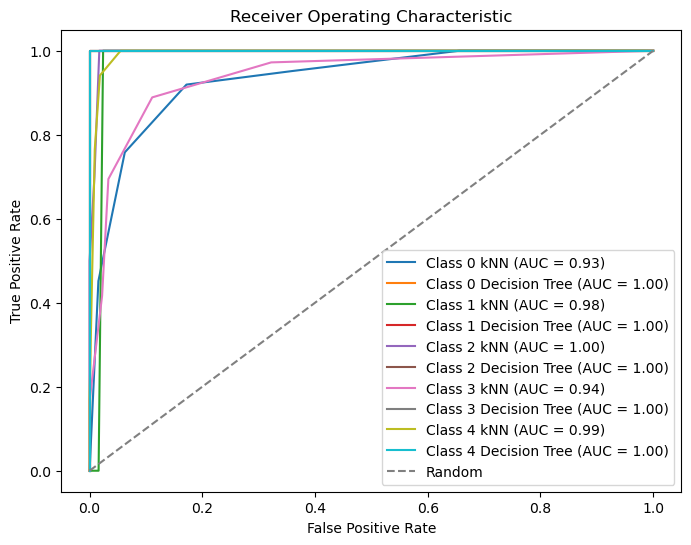

In [85]:
#ROC-AUC (площадь под ROC-кривой)
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Обучение kNN
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
knn.fit(X_train, y_train_bin)
y_score_knn = knn.predict_proba(X_test)

# Обучение дерева решений
tree = OneVsRestClassifier(DecisionTreeClassifier())
tree.fit(X_train, y_train_bin)
y_score_tree = tree.predict_proba(X_test)

# Рассчитываем ROC-кривые и площади под ними для каждого класса
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(len(np.unique(y_test))):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_score_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

fpr_tree = dict()
tpr_tree = dict()
roc_auc_tree = dict()
for i in range(len(np.unique(y_test))):
    fpr_tree[i], tpr_tree[i], _ = roc_curve(y_test_bin[:, i], y_score_tree[:, i])
    roc_auc_tree[i] = auc(fpr_tree[i], tpr_tree[i])

# Построение ROC-кривых для каждого класса
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr_knn[i], tpr_knn[i], label=f'Class {i} kNN (AUC = {roc_auc_knn[i]:.2f})')
    plt.plot(fpr_tree[i], tpr_tree[i], label=f'Class {i} Decision Tree (AUC = {roc_auc_tree[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [86]:

Результаты точности модели kNN равной 0.841 и точности модели дерева решений равной 1.0 отражают различия
в производительности и способности каждой модели к обучению на имеющихся данных.
Точность 0.841 указывает на то, что модель kNN правильно классифицировала около 84% тестовых примеров.
Это достаточно хороший показатель, но он может зависеть от параметров модели.
Точность 1.0 указывает на идеальное соответствие модели обучающим данным, что означает, что все примеры из тестового набора
были правильно классифицированы.

SyntaxError: invalid syntax (2332733926.py, line 1)